In [1]:
import os
import numpy as np
from scipy import stats
import pandas as pd
import arviz as az 
pd.options.mode.chained_assignment = None
import math
from scipy.stats import norm
import xarray
import matplotlib.pyplot as plt

In [2]:
#this function is for transforming the plots into the right parameter space
#(for parameters that got phi_approx in the model code)
def transform1(dataset):
    variable = norm.pdf(dataset.mu_pr.values)
    dataset.mu_pr.values = variable
    return dataset

In [3]:
#change working directory to where netCDF files are stored
#note: code for running model uses az.from_pystan to convert pystan fit into xarray dataset
#and then xarray dataset is exported as a netcdf file
os.chdir('nc_files')

In [4]:
#extract fit from netcdf file
standard_basic_fit = az.from_netcdf('standard_basic_fit.nc')
uncued_basic_fit = az.from_netcdf('uncued_basic_fit.nc')
loss_basic_fit = az. from_netcdf('loss_basic_fit.nc')
outcome_basic_fit = az.from_netcdf('outcome_basic_fit.nc')
random_basic_fit = az.from_netcdf('random_basic_fit.nc')
reverse_basic_fit = az.from_netcdf('reverse_basic_fit.nc')

In [5]:
standard_basic_fit

Inference data with groups:
	> posterior
	> sample_stats

In [6]:
uncued_basic_fit

Inference data with groups:
	> posterior
	> sample_stats

array([[<AxesSubplot:title={'center':'mu_pr'}>,
        <AxesSubplot:title={'center':'mu_pr'}>]], dtype=object)

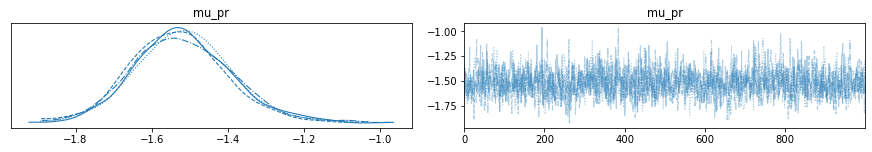

In [7]:
#extract posterior distribution for each group level parameter and plot them

#figures on left == posterior distribution for each of the chains --> should all overlap
#figures on right == trace plot for all four chains
#trace plot is a graph of the sampled parameter values as a function of the step in the chain 

# az.plot_trace(standard_basic_fit.posterior.mu_pr, coords = {'mu_pr_dim_0':[0,1,2,3]})
az.plot_trace(uncued_basic_fit.posterior.mu_pr, coords = {'mu_pr_dim_0':[0]})

In [8]:
sb_fit_mu = standard_basic_fit.posterior
sb_fit_sigma = standard_basic_fit.posterior

ub_fit_mu = uncued_basic_fit.posterior
# ub_fit_mu

<AxesSubplot:title={'center':'mu_pr'}>

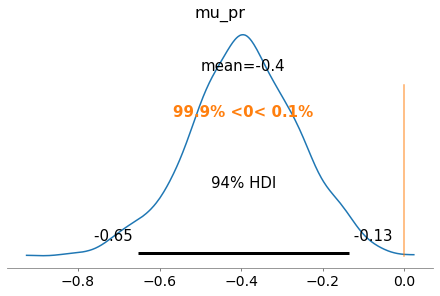

In [9]:
chain_1 = sb_fit_mu['mu_pr'][0]
chain_1 #the first chain, with 1000 draws
chain_1[:,0] #the first column of the first chain, representing mu_pr_0\

chain_2 = sb_fit_mu['mu_pr'][1]
chain_2
chain_2[:,0] #all the rows of the first column 

ub_chain_1 = ub_fit_mu['mu_pr'][0]
ub_chain_1 
ub_chain_1[:,0]

# dataset = pd.DataFrame({'mu_pr_0': chain_1[:, 0], 'mu_pr_1': chain_1[:, 1],'mu_pr_2': chain_1[:, 2],'mu_pr_3': chain_1[:, 3]})
# dataset

means_diff = chain_1[:,0] - ub_chain_1[:,0]
means_diff
az.plot_posterior(means_diff, ref_val=0)

In [25]:
sb_fit_mu['sigma'][0] #1st sigma chain
sb_fit_mu['sigma'][0][:,0] #all rows in the first column of the chain

<xarray.DataArray 'sigma' (draw: 1000)>
array([0.237268, 0.296936, 0.236245, ..., 0.173253, 0.172135, 0.161387])
Coordinates:
    chain        int64 0
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
    sigma_dim_0  int64 0

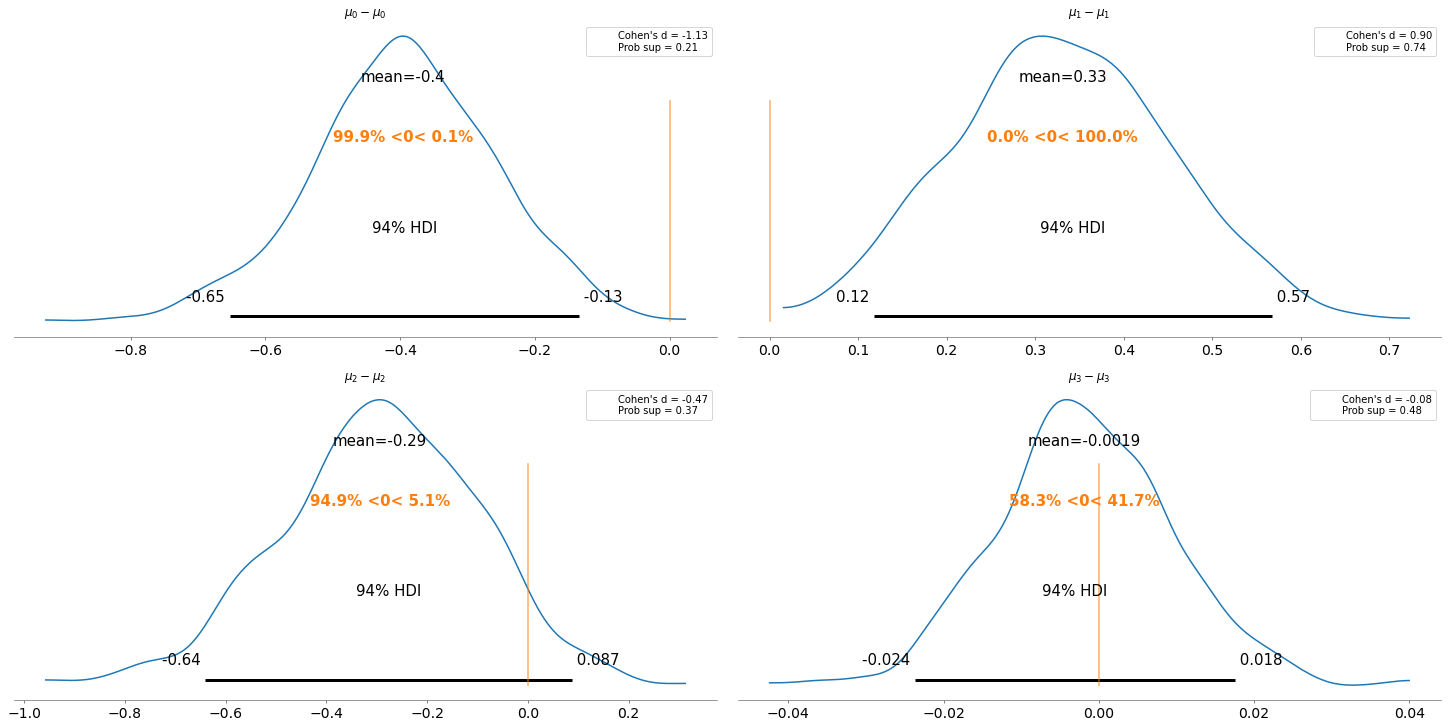

In [11]:
dist = stats.norm()

_, ax = plt.subplots(2, 2, figsize=(20, 10), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(4) if j == i]
pos = [(k, l) for k in range(2) for l in range(2)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = sb_fit_mu['mu_pr'][0][:, i] - ub_fit_mu['mu_pr'][0][:, j] #means_diff holds the sample difference distribution values
    d_cohen = (means_diff / np.sqrt((sb_fit_mu['sigma'][0][:, i]**2 + ub_fit_mu['sigma'][0][:, j]**2) / 2)).mean() #d_cohen is an xarray.DataArray
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l]) #plots posteriors in 2D array of locations 
    #for example, mu_0 - mu_0 will be in the 0,0 box (top left)
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen.values:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend();

In [12]:
def sample_diff(fit1, fit2):
    """Takes in fit1 and fit2 and outputs the sample difference distribution (fit1 - fit2) for the group parameters
    Also outputs Cohen's d, probability of superiority (Prob Sup)... and the distribution's mean, 94% HDI, and probability density to the left and right of 0"""
    #variables
    dist = stats.norm()
    _, ax = plt.subplots(2, 2, figsize=(20, 10), constrained_layout=True)
    comparisons = [(i, j) for i in range(4) for j in range(4) if j == i]
    pos = [(k, l) for k in range(2) for l in range(2)]

    #comparisons
    for (i, j), (k, l) in zip(comparisons, pos):
        means_diff = fit1.posterior['mu_pr'][0][:, i] - fit2.posterior['mu_pr'][0][:, j] #means_diff holds the sample difference distribution values
        d_cohen = (means_diff / np.sqrt((fit1.posterior['sigma'][0][:, i]**2 + fit2.posterior['sigma'][0][:, j]**2) / 2)).mean() #d_cohen is an xarray.DataArray
        ps = dist.cdf(d_cohen/(2**0.5))
        az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l]) #plots posteriors in 2D array of locations: for example, mu_0 - mu_0 will be in the 0,0 box (top left)
        ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
        ax[k, l].plot(0, label=f"Cohen's d = {d_cohen.values:.2f}\nProb sup = {ps:.2f}", alpha=0)
        ax[k, l].legend();

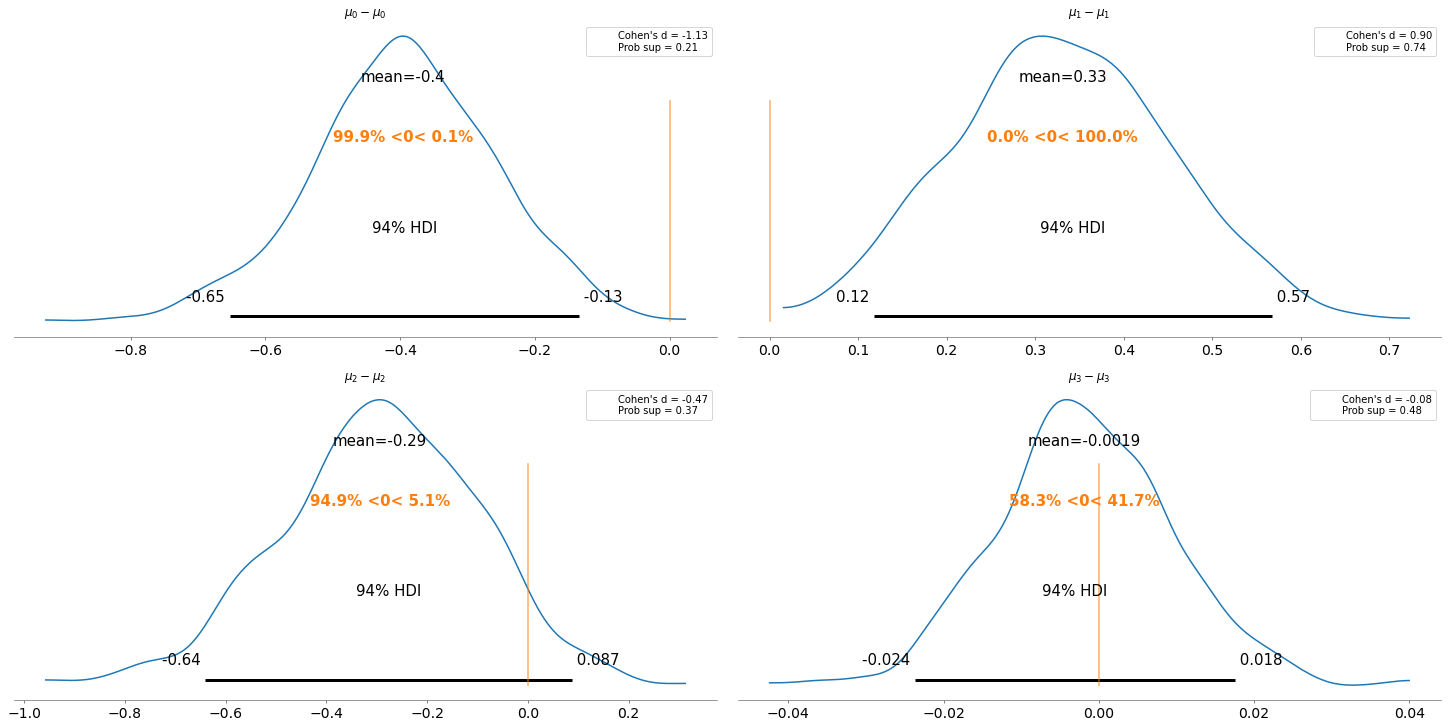

In [13]:
sample_diff(standard_basic_fit, uncued_basic_fit)

In [14]:
#print summary statistics 
#xarray.set_options(display_max_rows=264)
summary_fit = az.summary(standard_basic_fit)
pd.set_option('display.max_rows', summary_fit.shape[0]+1)
# print(summary_fit) #prints all rows 

In [15]:
# can convert to pandas dataframe (made no changes, runs fine) 
standard_basic_df = standard_basic_fit.to_dataframe()
# standard_basic_df.keys()
# standard_basic_df

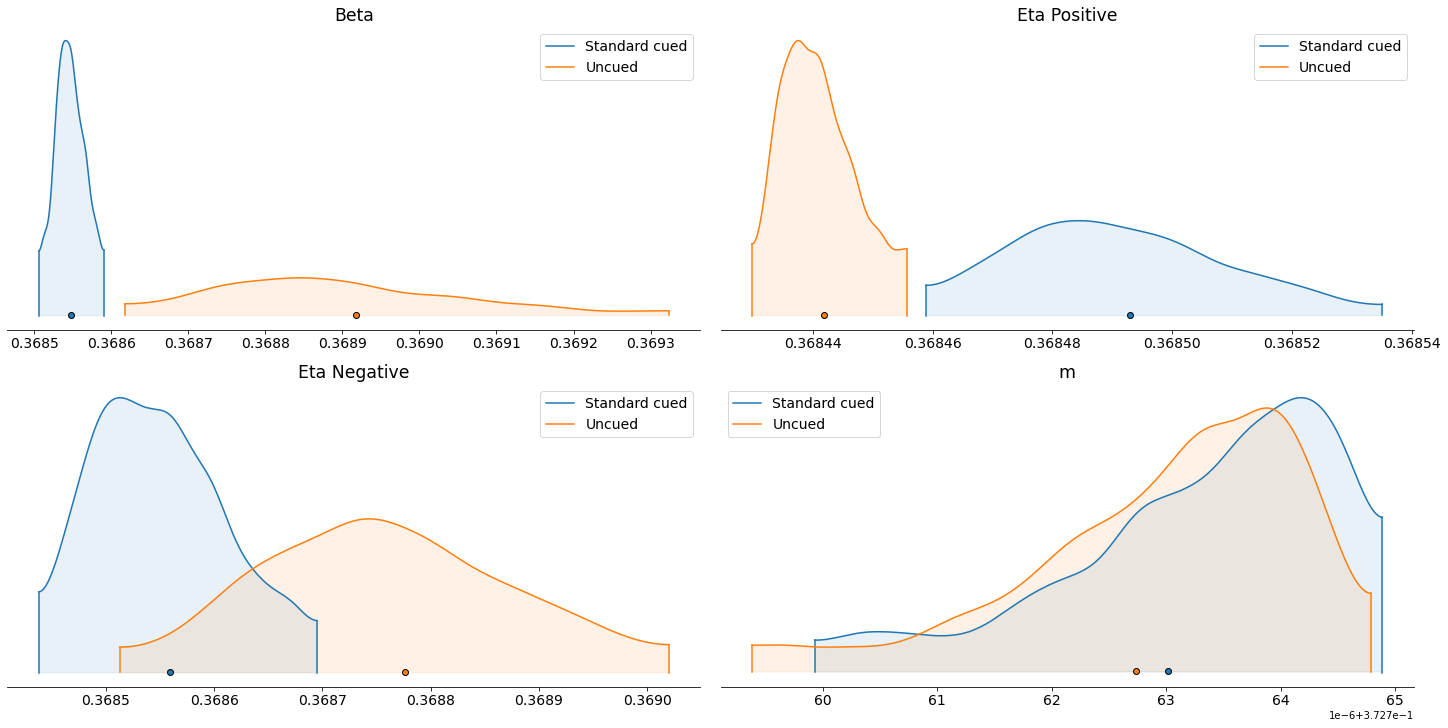

In [20]:
_, ax = plt.subplots(2, 2, figsize=(20, 10), constrained_layout=True)

params = ['Beta', 'Eta Positive', 'Eta Negative', 'm']
pos = [(k, l) for k in range(2) for l in range(2)]
comparisons = [(i, j) for i in range(4) for j in range(4) if j == i]
param = [m for m in range(len(params))]

for (k,l), (i,j), (m) in zip(pos, comparisons, param):
    az.plot_density([standard_basic_fit.posterior['mu_pr'][0][:, i],uncued_basic_fit.posterior['mu_pr'][0][:, j]], var_names = 'mu_pr', 
            data_labels = ['Standard cued', 'Uncued'],
            shade = 0.1, 
            hdi_prob = 0.95,
            transform = transform1,
            ax = ax[k,l])
    ax[k,l].set_title(params[m], fontsize = 'xx-large')

# WAIC 

In [22]:
az.waic(standard_basic_fit)

TypeError: log likelihood not found in inference data object

In [ ]:
# az.plot_forest(standard_basic_fit)

In [ ]:
# az.plot_violin(standard_basic_fit.posterior.beta)

In [ ]:
##WAIC

def softmax(x,beta):
    
    return np.exp(beta*x)/np.sum(np.exp(beta*x))

# calculate pointwise log-likelihood (ie for each datapoint)


#run chosen option through softmax equation, beta*V? with categorical logit PDF? not sure if I then take the maximum of this??

#then need to actually calculate WAIC

#point estimates and standard errors of the expected log pointwise predictive density 

#multiplied by -2